In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from data import fMRIData
from operators import MRI, Operator
from torch import nn
from torch.utils.data import DataLoader
from networks import ResNet, ConvNet, ConvenientModel
import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

In [10]:
EXPERIMENT = 'MRI_fMRIData_Sobolev_0_Exp_1'
# Data Setup
NOISE_LEVEL = 1e-3
N_ANGLES = 60
INITIAL_MINIMIZATION = False

# Network training
LEARNING_RATE = 5e-5
BATCH_SIZE = 16
TRAINING_STEPS = 20000
# Regulariser architecture
CHANNELS = [1, 64, 128, 128]
DOWNSAMPLING = [False, True, True]
SOBOLEV = 0
# regularisation parameter for gradient penalty
MU = 10
# scales gradient norm with average image norm. Normalizes expected distributional distance to 1.
AVERAGE_IMAGE_NORM = 1

# solving the variational problem
LAMBDA = 5.0
N_STEPS = 80
STEP_SIZE = .1
THRESHOLDING = False
# tracking
N_IMAGES_LOGGING = 1
TRACKING_FREQ = 100
# Saves
BASE_PATH = '/store/CCIMI/sl767/Experiments/'

Sampling pattern loaded
Created directory /store/CCIMI/sl767/Experiments/MRI_fMRIData_Sobolev_0_Exp_1/ResNets/64_0_128_1_128_1_Neurons_128/
No save found
Number of training samples found 1304394


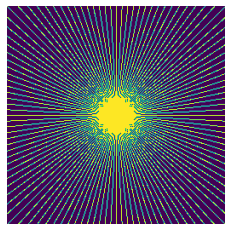

MRI Operator
Resolution 256
Subsampling level: 0.24310302734375

In [3]:
tracker = SummaryWriter(BASE_PATH+f'{EXPERIMENT}/Logs/')
operator = MRI(n_directions=N_ANGLES)
regulariser = ResNet(channels=CHANNELS, downsamples=DOWNSAMPLING, base_path=BASE_PATH, exp_name=EXPERIMENT).cuda()
data = DataLoader(fMRIData(), batch_size=BATCH_SIZE)
optimizer = optim.Adam(regulariser.parameters(), lr=LEARNING_RATE)
operator

In [4]:
def get_training_data(gt):
    y = operator.add_noise(operator.forward_torch(gt), NOISE_LEVEL)
    x_0 = operator.inverse_torch(y)
    # potentially add a solution of variational problem at this point
    if INITIAL_MINIMIZATION:
        x_0 = solve_variational_problem(x_0, y, 10, .1, 0, tracking=None)
    return x_0, y

In [5]:
def l2(x):
#     return torch.sqrt(torch.sum(x ** 2, dim=(1,2,3)))
    return torch.mean(torch.sqrt(torch.sum(x ** 2, dim=(1,2,3))))

In [6]:
def get_optimal_lambda():
    gt = next(iter(data)).cuda()
    _, y = get_training_data(gt)
    norm_data = l2(operator.adjoint_torch(operator.forward_torch(gt) - y))
    return norm_data.item()
get_optimal_lambda()

5.526275157928467

In [12]:
def solve_variational_problem(x_0, y, n_steps, step_size, lam, tracking=None, x_gt=None, global_step=None):
    '''
    Solves the variational problem starting at x_0, with data term y, n_steps 
    descent steps and regularisation paremeter mu.
    param tracking: Supports values None (no tracking), Variational (writes full tracking history into seperate dir) 
    and 'BestOnly' (writes best value over trajectory to training logger)
    '''
    if tracking == 'Variational':
        p = BASE_PATH+f'{EXPERIMENT}/Logs/Step_{global_step}/Lambda_{lam}/'
        print('Writing variational minimization to directory', p)
        local_writer = SummaryWriter(p)
    def add_scalar(name, value, iteration):
        if tracking == 'Variational':
            local_writer.add_scalar('Variational/'+name, value, iteration)
    def add_image(name, value, iteration):
        if tracking == 'Variational':
            value = torch.clamp(value, 0, 1)
            if value.shape[0] < N_IMAGES_LOGGING:
                v = value.cpu().numpy()
            else:
                v = (value[:N_IMAGES_LOGGING]).cpu().numpy()
            local_writer.add_images('Variational/'+name, v, iteration)
            
    best_per = -1
    best_attained_at = -1
    best_recon = None
    x = x_0.detach()
    add_image('Ground Truth', gt, 0)
    for k in range(n_steps):
        data_term = operator.forward_torch(x) - y
        add_scalar('Data_Term', l2(data_term).detach().cpu().numpy(), k)
        data_grad = operator.adjoint_torch(data_term)
        add_scalar('Norm_Data_Gradient', l2(data_grad).detach().cpu().numpy(), k)
        if tracking  == 'Variational':
            quality = (l2(x_gt-x)).mean().detach().cpu().numpy()
            add_scalar('Quality', quality, k)
            add_image('Reconstruction', x, k)
        if not lam == 0:
            reg_grad = AVERAGE_IMAGE_NORM*regulariser.gradient(x)
            add_scalar('Norm_Regulariser_Gradient', l2(reg_grad).detach().cpu().numpy(), k)
            x = x - step_size * (data_grad + lam*reg_grad)
        else:
            x = x - step_size * data_grad
        if THRESHOLDING:
            x = torch.clamp(x, 0, 1)
        if tracking == 'BestOnly':
            quality = (l2(x_gt-x)).mean().detach().cpu().numpy()
            if quality < best_per or best_per == -1:
                best_attained_at = k
                best_per = quality
                best_recon = torch.clamp(x, 0, 1).detach().cpu().numpy()[0,...]
    if tracking == 'BestOnly':
        plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.imshow(best_recon[0,...])
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(x_gt.cpu()[0,0,...])
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(x_0.cpu()[0,0,...])
        plt.axis('off')
        plt.show()
        tracker.add_scalar('Network_Training/Reconstruction_Quality', best_per, global_step)
        tracker.add_scalar('Network_Training/Best_Attained_At', best_attained_at, global_step)
        tracker.add_image('Network_Training/Reconstruction', best_recon, global_step)
        tracker.add_image('Network_Training/Ground Truth', torch.clamp(gt[0,...], 0, 1).cpu().numpy(), global_step)
        tracker.add_image('Network_Training/FBP', torch.clamp(x_0[0,...], 0, 1).cpu().numpy(), global_step)
        
    return x

In [8]:
def gradient_penalty(gt, fbp, sobolev=0, tracking=False, global_step=None):
    batch_size = gt.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).cuda()
    alpha = alpha.expand_as(gt)
    interpolated = Variable(alpha * gt + (1 - alpha) * fbp, requires_grad=True)

    # Calculate probability of interpolated examples
    prob_interpolated = torch.sum(regulariser(interpolated))

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           create_graph=True, retain_graph=True)[0]

    gradients_norm = AVERAGE_IMAGE_NORM*torch.sqrt(torch.sum(gradients ** 2, dim=(1,2,3)) + 1e-12)
    assert len(gradients_norm.shape) == 1 and gradients_norm.shape[0] == BATCH_SIZE
    penalty = ((torch.nn.ReLU()(gradients_norm - 1)) ** 2).mean()
    if tracking:
        tracker.add_scalar('Network_Training/Gradient_Norm', gradients_norm.mean().detach().cpu().numpy(), global_step)
        tracker.add_scalar('Network_Training/Gradient_Penalty', penalty.detach().cpu().numpy(), global_step)
        
    # Return gradient penalty
    return penalty

Model loaded. Step 5000


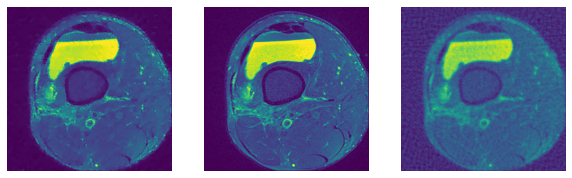

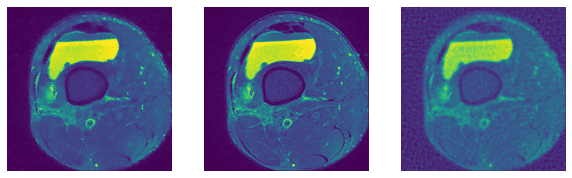

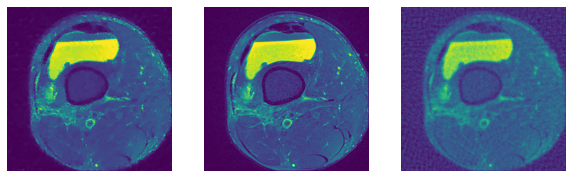

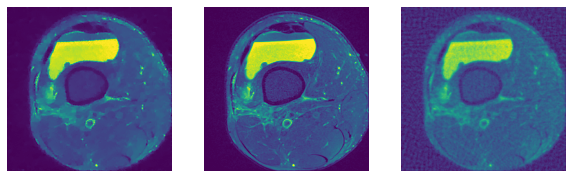

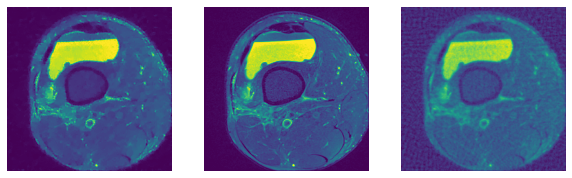

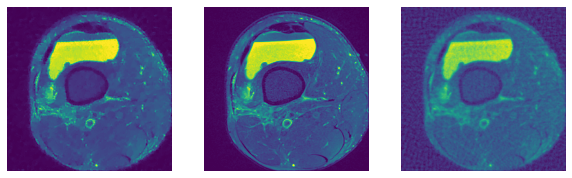

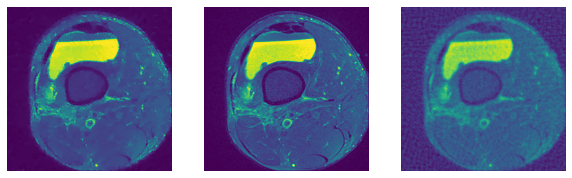

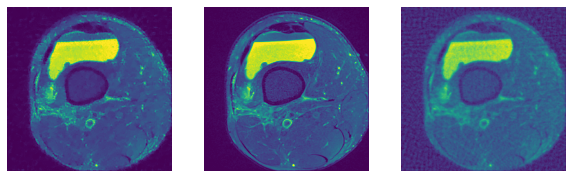

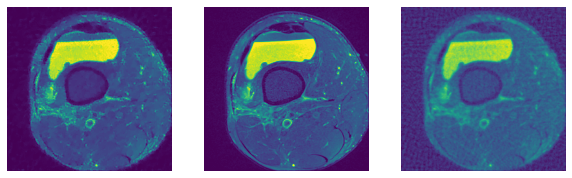

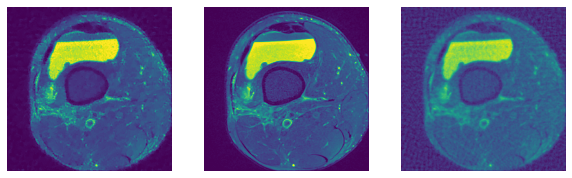

Writing variational minimization to directory /store/CCIMI/sl767/Experiments/MRI_fMRIData_Sobolev_0_Exp_1/Logs/Step_6000/Lambda_5.0/


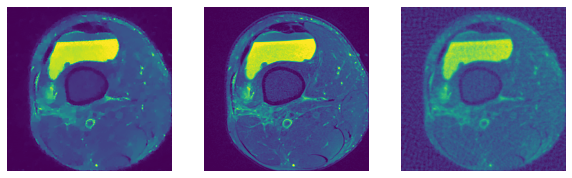

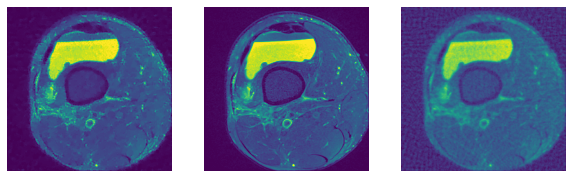

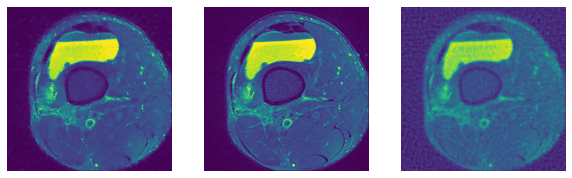

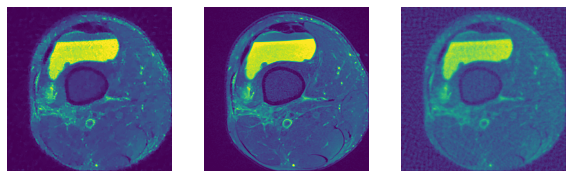

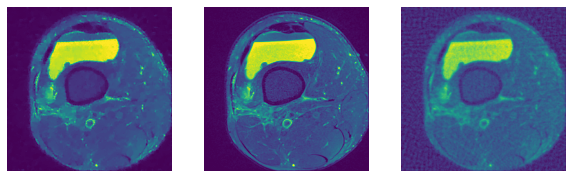

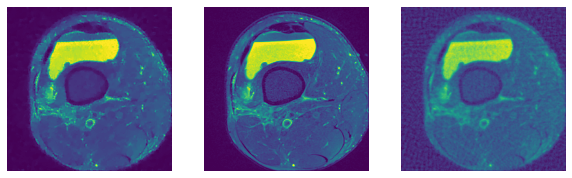

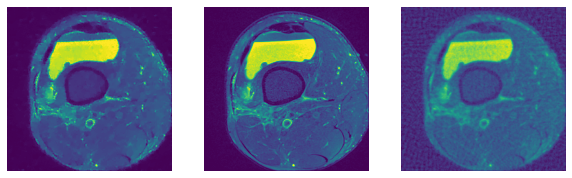

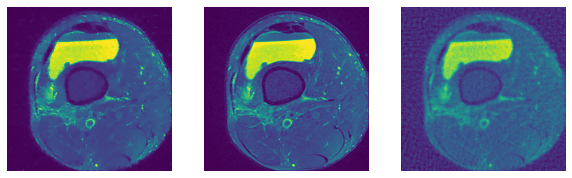

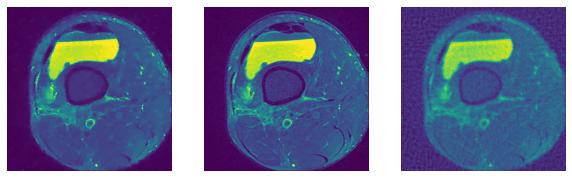

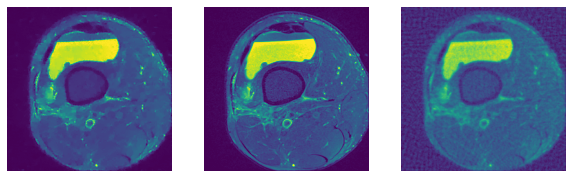

Writing variational minimization to directory /store/CCIMI/sl767/Experiments/MRI_fMRIData_Sobolev_0_Exp_1/Logs/Step_7000/Lambda_5.0/


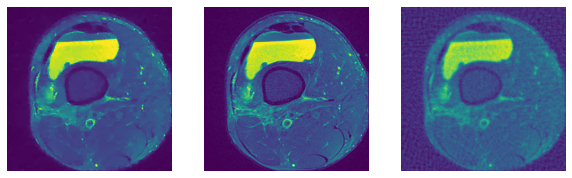

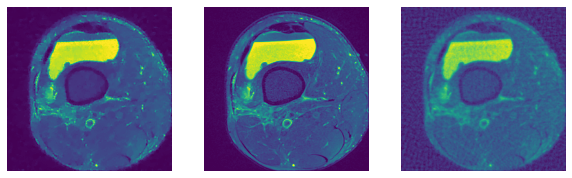

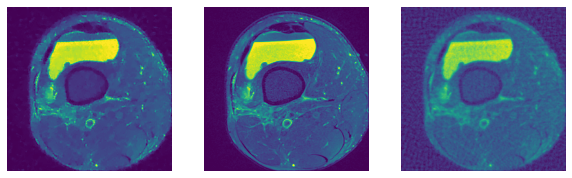

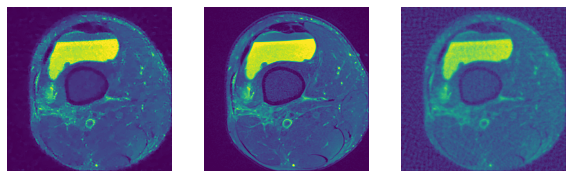

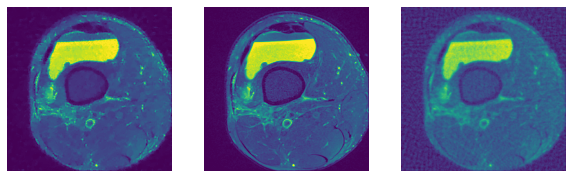

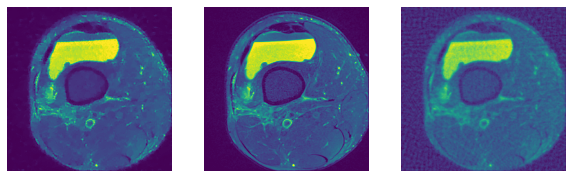

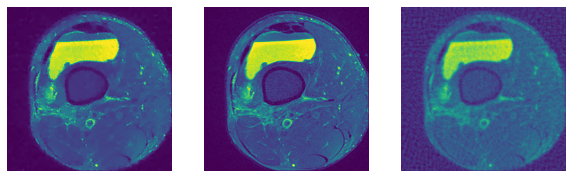

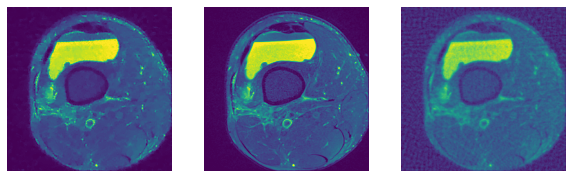

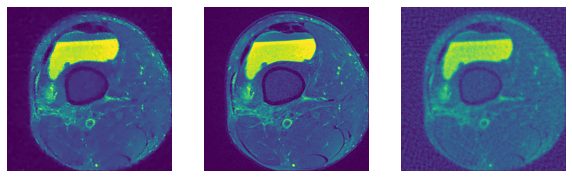

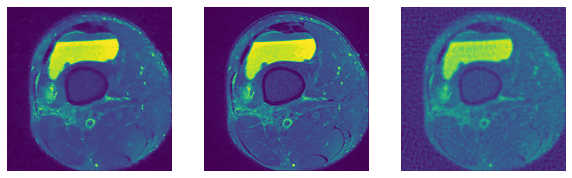

Writing variational minimization to directory /store/CCIMI/sl767/Experiments/MRI_fMRIData_Sobolev_0_Exp_1/Logs/Step_8000/Lambda_5.0/


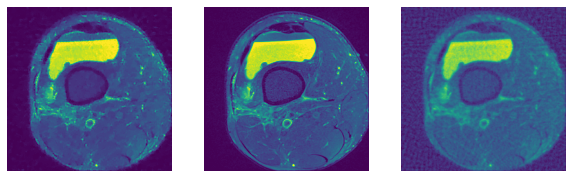

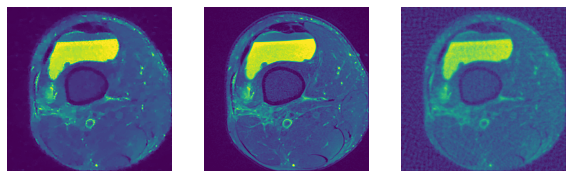

In [ ]:
global_step = regulariser.load()
# TODO: Change this to validation data set
val_gt = next(iter(data)).cuda()
val_fbp, val_y = get_training_data(val_gt)

for _ in range(1000):
    for i, gt in enumerate(data):
        if global_step >= TRAINING_STEPS:
            regulariser.save(global_step)
            break
        gt = gt.cuda()
        # get training data
        fbp, y = get_training_data(gt)
        # compute the training loss
        loss = (regulariser(gt) - regulariser(fbp))
        r = gradient_penalty(gt, fbp, tracking=True, global_step=global_step)
        overall_loss = (loss + LAMBDA*r).mean()
        tracker.add_scalar('Network_Training/Distributional_Distance', loss.mean().detach().cpu().numpy(), global_step)
        tracker.add_scalar('Network_Training/Training_Loss', overall_loss.detach().cpu().numpy(), global_step)
        # update network parameters
        overall_loss.backward()
        optimizer.step()
        regulariser.zero_grad()

        # solve the variational problem
        if i%TRACKING_FREQ == 0:
            solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=LAMBDA, x_gt=val_gt, 
                                      global_step=global_step, tracking='BestOnly')
        global_step += 1
        if global_step % 1000 == 0:
            solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=LAMBDA, x_gt=val_gt, 
                      global_step=global_step, tracking='Variational')
            regulariser.save(global_step)
    if global_step >= TRAINING_STEPS:
        break

gt = next(iter(data)).cuda()
fbp, y = get_training_data(gt)
for l in [LAMBDA/3, LAMBDA, LAMBDA*3]:
    solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=l, x_gt=val_gt, 
              global_step=global_step, tracking='Variational')
    